In [503]:
# IMPORT GENERIC PACKAGES
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.cluster.vq import whiten
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np # numerical calc package
import pandas as pd # holds data
import matplotlib.pyplot as plt # plotting library
import seaborn as sns # pretty plotting

In [504]:
df = pd.read_csv("heart_attack_risk_dataset - heart_attack_risk_dataset.csv")
print(df.dtypes)

Age                          int64
Gender                      object
Smoking                      int64
Alcohol_Consumption          int64
Physical_Activity_Level     object
BMI                        float64
Diabetes                     int64
Hypertension                 int64
Cholesterol_Level          float64
Resting_BP                   int64
Heart_Rate                   int64
Family_History               int64
Stress_Level                object
Chest_Pain_Type             object
Thalassemia                 object
Fasting_Blood_Sugar          int64
ECG_Results                 object
Exercise_Induced_Angina      int64
Max_Heart_Rate_Achieved      int64
Heart_Attack_Risk           object
dtype: object


In [505]:
df_risks_factors = df[['Smoking','Alcohol_Consumption','Diabetes','Hypertension','Family_History','Fasting_Blood_Sugar','Exercise_Induced_Angina']].sum(axis=1)
df_risks_factors

0        2
1        0
2        1
3        3
4        1
        ..
49995    0
49996    1
49997    2
49998    1
49999    0
Length: 50000, dtype: int64

In [506]:
df.head()

,Age,Gender,Smoking,Alcohol_Consumption,Physical_Activity_Level,BMI,Diabetes,Hypertension,Cholesterol_Level,Resting_BP,Heart_Rate,Family_History,Stress_Level,Chest_Pain_Type,Thalassemia,Fasting_Blood_Sugar,ECG_Results,Exercise_Induced_Angina,Max_Heart_Rate_Achieved,Heart_Attack_Risk
0,69,Female,1,0,Moderate,34.61,1,0,152.1,171,85,0,Moderate,Non-anginal,Reversible defect,0,Normal,0,114,Low
1,32,Male,0,0,Moderate,22.75,0,0,166.8,126,103,0,Low,Asymptomatic,Normal,0,ST-T abnormality,0,173,Moderate
2,89,Male,0,1,Moderate,35.32,0,0,272.3,123,127,0,Low,Typical,Reversible defect,0,ST-T abnormality,0,109,Low
3,78,Male,0,1,Moderate,18.23,1,0,237.7,144,125,0,Low,Typical,Fixed defect,1,Left Ventricular Hypertrophy,0,129,Low
4,38,Female,1,0,Moderate,19.82,0,0,207.7,123,107,0,High,Asymptomatic,Reversible defect,0,ST-T abnormality,0,124,Moderate


In [507]:
# Define the bins and labels for generations
bins = [0, 28, 44, 60, 79, float('inf')]  # Age ranges for each generation
labels = ['Gen Z', 'Millennials', 'Gen X', 'Baby Boomers', 'Silent Gen']

# Bin the 'Age' column
df['Generation'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

In [508]:
## Converting Categorical data to numbers

In [509]:
# Encoding 'Sex' column: Female = 0, Male = 1
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

# Encoding 'Physical_Activity_Level' column: Unhealthy = 0, Average = 1, Healthy = 2
df['Physical_Activity_Level'] = df['Physical_Activity_Level'].map({'Low': 2, 'Moderate': 1, 'High': 0})

# Encoding 'Stress_Level' column: Unhealthy = 0, Average = 1, Healthy = 2
df['Stress_Level'] = df['Stress_Level'].map({'Low': 2, 'Moderate': 1, 'High': 0})

df['ECG_Abnormal'] = df.ECG_Results.apply(lambda x: 0 if x < 'Normal' else 1)
df['Chest_Pain_Results'] = df['Chest_Pain_Type'].apply(lambda x: 1 if ('Typical' in x or 'Atypical' in x) else 0)
df['RBP_High'] = df['Resting_BP'].apply(lambda x: 0 if x <= 130 else 1)
df['Thal_Results'] = df.Thalassemia.apply(lambda x: 0 if x < 'Normal' else 1)
df['HeartAttack_Risk'] = df['Heart_Attack_Risk'].map({'Low': 0, 'Moderate': 1, 'High': 2})
df['Age_Generation'] = df['Generation'].map({'Gen Z': 0, 'Millennials': 1, 'Gen X': 2, 'Baby Boomers':3, 'Silent Gen':4 })

# Verify the encoding
print(df[['Gender','Physical_Activity_Level','Stress_Level','ECG_Abnormal','Chest_Pain_Results','Thal_Results','RBP_High']].head())

   Gender  Physical_Activity_Level  Stress_Level  ECG_Abnormal  \
0       0                        1             1             1   
1       1                        1             2             1   
2       1                        1             2             1   
3       1                        1             2             0   
4       0                        1             0             1   

   Chest_Pain_Results  Thal_Results  RBP_High  
0                   0             1         1  
1                   0             1         0  
2                   1             1         0  
3                   1             0         1  
4                   0             1         0  


In [510]:
# Define the order of categories
bmi_categories_order = ["Underweight", "Normal weight", "Overweight", "Obese"]  
df['BMI_Category_Numerical'] = pd.Categorical(df['BMI'].apply(lambda bmi:
                                                            "Underweight" if bmi < 18.5 else 
                                                            "Normal weight" if 18.5 <= bmi < 25 else 
                                                            "Overweight" if 25 <= bmi < 30 else "Obese"), 
                                              categories=bmi_categories_order, ordered=True).codes

cholesterol_order = ["Desirable", "Borderline High", "High"]
df['Cholesterol_Category_Numerical'] = pd.Categorical(df['Cholesterol_Level'].apply(lambda chol:
                                                            "Desirable" if chol < 200 else 
                                                            "Borderline High" if 200 <= chol < 240 else 
                                                            "High"), categories=cholesterol_order, ordered=True).codes


In [511]:
# Reorder columns: move 'Heart Attack Risk' to the most right
cols = [col for col in df.columns if col != 'Heart_Attack_Risk']  # All columns except 'Heart Attack Risk'
df_fixed = df[cols + ['Heart_Attack_Risk']]  # Append 'Heart Attack Risk' to the rightmost position

# Verify the changes
df_fixed

,Age,Gender,Smoking,Alcohol_Consumption,Physical_Activity_Level,BMI,Diabetes,Hypertension,Cholesterol_Level,Resting_BP,...,Generation,ECG_Abnormal,Chest_Pain_Results,RBP_High,Thal_Results,HeartAttack_Risk,Age_Generation,BMI_Category_Numerical,Cholesterol_Category_Numerical,Heart_Attack_Risk
0,69,0,1,0,1,34.61,1,0,152.1,171,...,Baby Boomers,1,0,1,1,0,3,3,0,Low
1,32,1,0,0,1,22.75,0,0,166.8,126,...,Millennials,1,0,0,1,1,1,1,0,Moderate
2,89,1,0,1,1,35.32,0,0,272.3,123,...,Silent Gen,1,1,0,1,0,4,3,2,Low
3,78,1,0,1,1,18.23,1,0,237.7,144,...,Baby Boomers,0,1,1,0,0,3,0,1,Low
4,38,0,1,0,1,19.82,0,0,207.7,123,...,Millennials,1,0,0,1,1,1,1,1,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,21,1,0,0,2,39.93,0,0,269.9,171,...,Gen Z,1,1,1,1,2,0,3,2,High
49996,35,0,0,0,2,18.10,0,0,235.8,146,...,Millennials,1,0,1,0,1,1,0,1,Moderate
49997,46,1,0,1,0,21.42,0,0,172.8,146,...,Gen X,0,1,1,0,0,2,1,0,Low
49998,56,1,0,1,2,29.93,0,0,244.1,151,...,Gen X,1,0,1,1,1,2,2,2,Moderate


In [512]:
df_fixed = df.drop(columns=["Heart_Attack_Risk","ECG_Results","Thalassemia","Chest_Pain_Type","Generation"],axis=1)
df_fixed

,Age,Gender,Smoking,Alcohol_Consumption,Physical_Activity_Level,BMI,Diabetes,Hypertension,Cholesterol_Level,Resting_BP,...,Exercise_Induced_Angina,Max_Heart_Rate_Achieved,ECG_Abnormal,Chest_Pain_Results,RBP_High,Thal_Results,HeartAttack_Risk,Age_Generation,BMI_Category_Numerical,Cholesterol_Category_Numerical
0,69,0,1,0,1,34.61,1,0,152.1,171,...,0,114,1,0,1,1,0,3,3,0
1,32,1,0,0,1,22.75,0,0,166.8,126,...,0,173,1,0,0,1,1,1,1,0
2,89,1,0,1,1,35.32,0,0,272.3,123,...,0,109,1,1,0,1,0,4,3,2
3,78,1,0,1,1,18.23,1,0,237.7,144,...,0,129,0,1,1,0,0,3,0,1
4,38,0,1,0,1,19.82,0,0,207.7,123,...,0,124,1,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,21,1,0,0,2,39.93,0,0,269.9,171,...,0,122,1,1,1,1,2,0,3,2
49996,35,0,0,0,2,18.10,0,0,235.8,146,...,0,121,1,0,1,0,1,1,0,1
49997,46,1,0,1,0,21.42,0,0,172.8,146,...,0,125,0,1,1,0,0,2,1,0
49998,56,1,0,1,2,29.93,0,0,244.1,151,...,0,149,1,0,1,1,1,2,2,2


In [513]:
print(df_fixed.dtypes)

Age                                  int64
Gender                               int64
Smoking                              int64
Alcohol_Consumption                  int64
Physical_Activity_Level              int64
BMI                                float64
Diabetes                             int64
Hypertension                         int64
Cholesterol_Level                  float64
Resting_BP                           int64
Heart_Rate                           int64
Family_History                       int64
Stress_Level                         int64
Fasting_Blood_Sugar                  int64
Exercise_Induced_Angina              int64
Max_Heart_Rate_Achieved              int64
ECG_Abnormal                         int64
Chest_Pain_Results                   int64
RBP_High                             int64
Thal_Results                         int64
HeartAttack_Risk                     int64
Age_Generation                    category
BMI_Category_Numerical                int8
Cholesterol

In [514]:
##Scaling the data
 #MinMaxScaler
scaler = MinMaxScaler()

# Scale all columns (since they are all numerical)
df_scaled = pd.DataFrame(scaler.fit_transform(df_fixed), columns=df_fixed.columns)

print(df_scaled.head())

        Age  Gender  Smoking  Alcohol_Consumption  Physical_Activity_Level  \
0  0.718310     0.0      1.0                  0.0                      0.5   
1  0.197183     1.0      0.0                  0.0                      0.5   
2  1.000000     1.0      0.0                  1.0                      0.5   
3  0.845070     1.0      0.0                  1.0                      0.5   
4  0.281690     0.0      1.0                  0.0                      0.5   

      BMI  Diabetes  Hypertension  Cholesterol_Level  Resting_BP  ...  \
0  0.7844       1.0           0.0           0.014000    0.910112  ...   
1  0.3100       0.0           0.0           0.112000    0.404494  ...   
2  0.8128       0.0           0.0           0.815333    0.370787  ...   
3  0.1292       1.0           0.0           0.584667    0.606742  ...   
4  0.1928       0.0           0.0           0.384667    0.370787  ...   

   Exercise_Induced_Angina  Max_Heart_Rate_Achieved  ECG_Abnormal  \
0                      

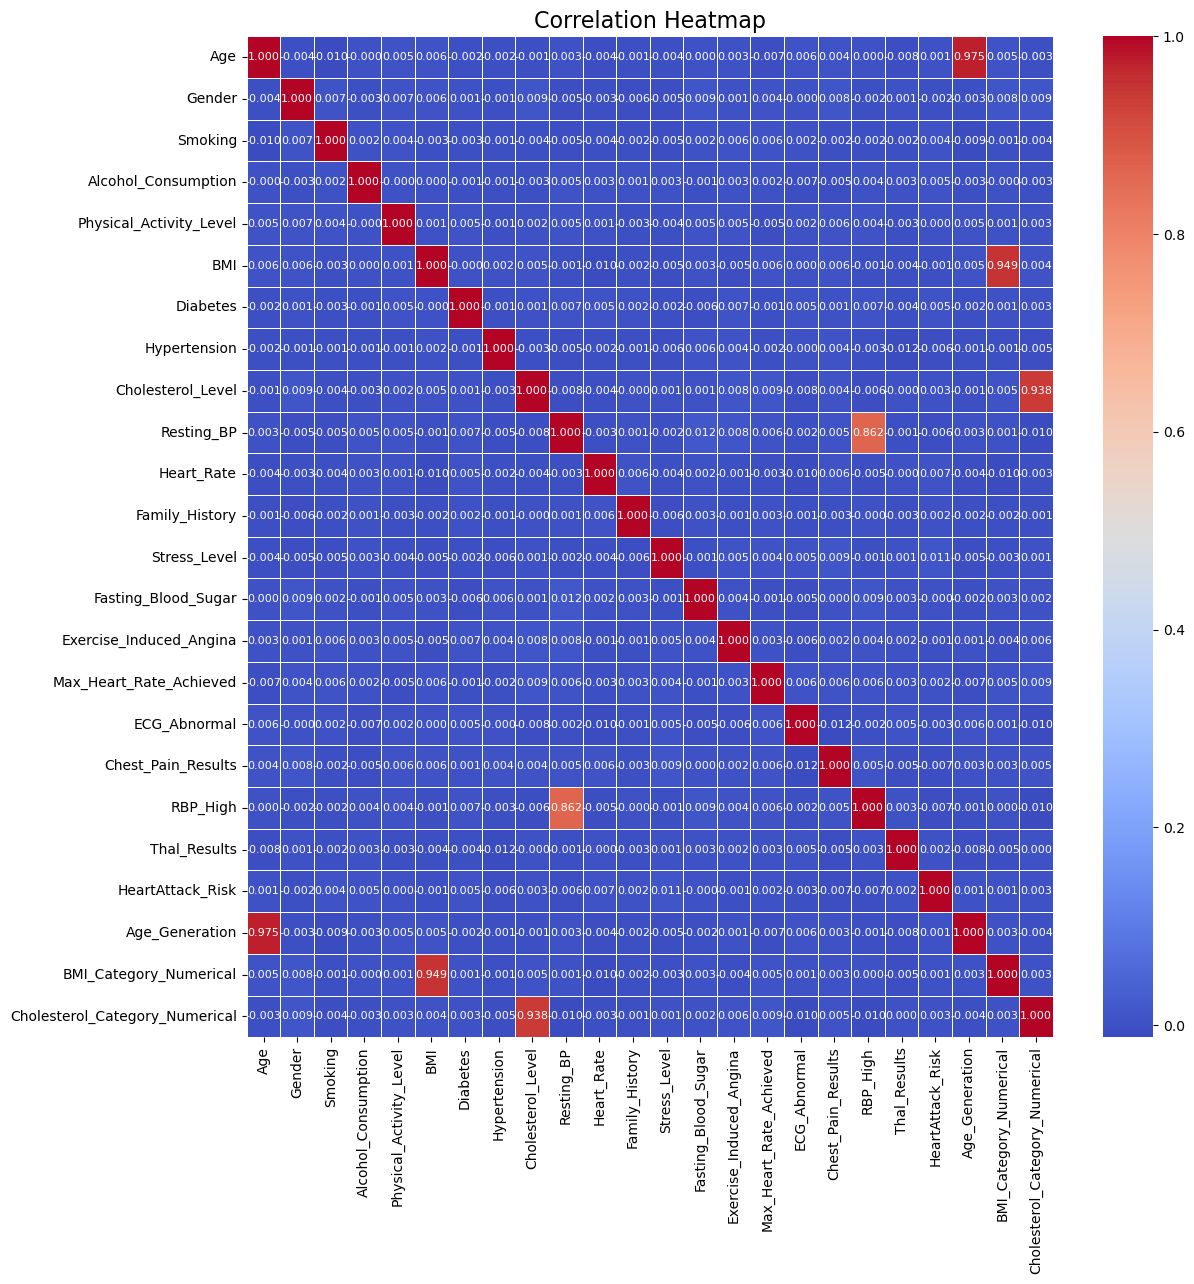

In [515]:
# Compute the correlation matrix
correlation_matrix = df_fixed.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(13, 13
                ))  # Adjust figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5, annot_kws={"size": 8} )

# Customize the plot
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

HeartAttack_Risk                  1.000000
Stress_Level                      0.010557
Heart_Rate                        0.006851
Alcohol_Consumption               0.004921
Diabetes                          0.004870
Smoking                           0.004299
Cholesterol_Category_Numerical    0.003196
Cholesterol_Level                 0.002882
Max_Heart_Rate_Achieved           0.002290
Family_History                    0.001934
Thal_Results                      0.001644
BMI_Category_Numerical            0.001368
Age                               0.000693
Age_Generation                    0.000592
Physical_Activity_Level           0.000447
Fasting_Blood_Sugar              -0.000055
BMI                              -0.000665
Exercise_Induced_Angina          -0.001151
Gender                           -0.002439
ECG_Abnormal                     -0.003274
Resting_BP                       -0.006178
Hypertension                     -0.006405
RBP_High                         -0.007166
Chest_Pain_

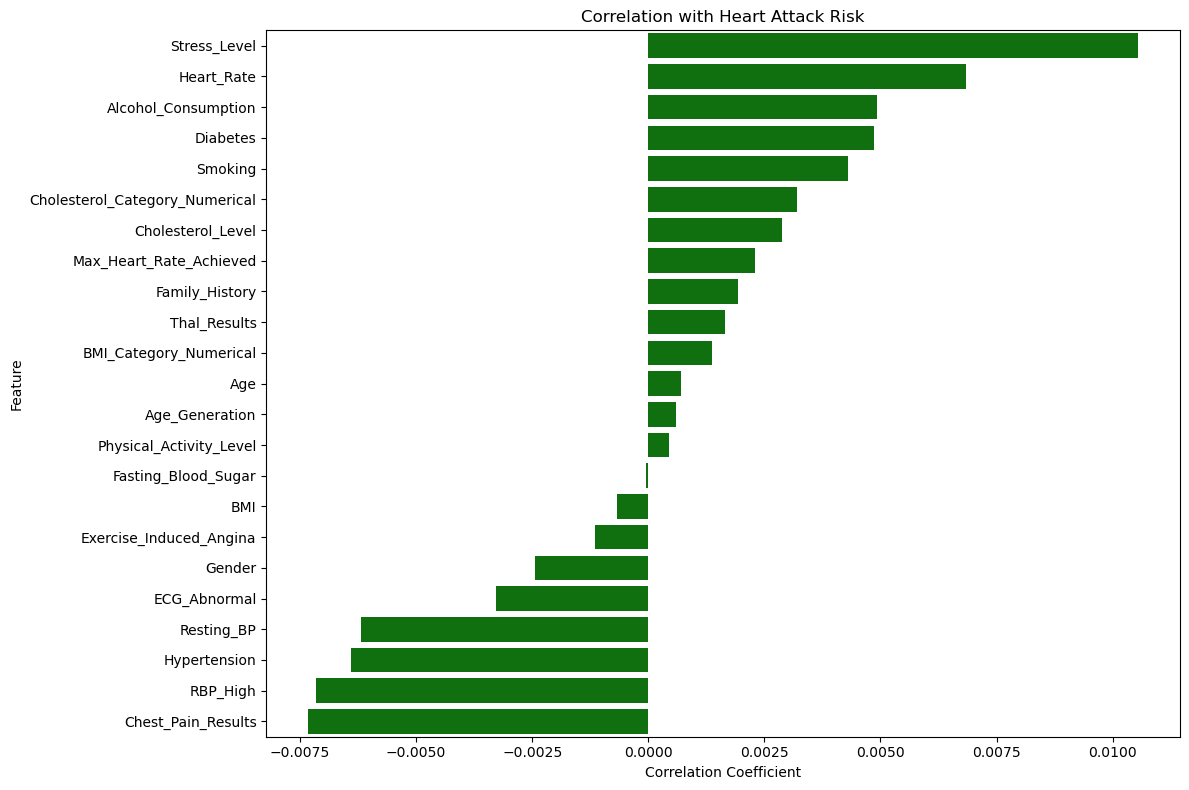

In [516]:
correlation_with_success = correlation_matrix['HeartAttack_Risk']

# Sort the correlation values in descending order
correlation_ranked = correlation_with_success.sort_values(ascending=False)

# Print the ranked correlation values
print(correlation_ranked)

# Drop 'HeartAttack_Risk' from the Series
correlation_ranked = correlation_ranked.drop('HeartAttack_Risk')

# 1. Bar Plot (Horizontal):
plt.figure(figsize=(12, 8))
sns.barplot(x=correlation_ranked.values, y=correlation_ranked.index, color='green')
plt.title('Correlation with Heart Attack Risk')  # Update title
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [517]:
print(list(df_scaled.columns))

['Age', 'Gender', 'Smoking', 'Alcohol_Consumption', 'Physical_Activity_Level', 'BMI', 'Diabetes', 'Hypertension', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 'Family_History', 'Stress_Level', 'Fasting_Blood_Sugar', 'Exercise_Induced_Angina', 'Max_Heart_Rate_Achieved', 'ECG_Abnormal', 'Chest_Pain_Results', 'RBP_High', 'Thal_Results', 'HeartAttack_Risk', 'Age_Generation', 'BMI_Category_Numerical', 'Cholesterol_Category_Numerical']


In [518]:
##Feature engineering

def prepare_data(df):
  ### USE THIS FUNCTION AS YOUR DATA PREP FUNCTION
  ### don't do any dataprep/FE outside of this function
  ##################################################################
  df = df.copy(deep=True)
  #################################################################
  # Basic example (Comment these out when ready)
  # If we wanted to select only the numeric covariates:
  ####### EDIT STARTING HERE #############

  df['Chol_Result'] = df.Cholesterol_Level.apply(lambda x: 0 if x < 200 else 1)
  df['Lifestyle_Score']= df['Smoking'] + df['Alcohol_Consumption'] + df['Age']
  df['Lifestyle_Scores']= df.Lifestyle_Score.apply(lambda x: 1 if x > 0 else 1)
  df['FBS_Dia'] = df['Fasting_Blood_Sugar'] + df['Diabetes']
  df['Health_Score']= df['FBS_Dia'] + df['Hypertension']
  df['Health_Scores']= df.Health_Score.apply(lambda x: 0 if x < 1 else 1)  
  df['DD']= df.Lifestyle_Score.apply(lambda x: 0 if x < 1 else 1)
  df['Family_Age'] = df['Family_History'] + df['Age']
  df['Age_Lifestyle']= df['Age']*df['Lifestyle_Score']
  df['Test_Results']=  df[['Chest_Pain_Results','Thal_Results','ECG_Abnormal']].sum(axis=1)
  df['Chest_Pain_ECG_Related'] = df['Chest_Pain_Results'] + df['ECG_Abnormal']
  df['Heart_Attack_Risk'] = df['HeartAttack_Risk'].map({0: "Low", .5: "Moderate", 1: "High"})
  df['Age_Tests'] = df['Age_Generation'] * df['Test_Results']

  df = df[["Heart_Attack_Risk", ## Always included
           ## Follow with all other covariates
        'Age_Generation','Family_Age', 'Lifestyle_Score', 'Physical_Activity_Level','BMI_Category_Numerical', 'Cholesterol_Level', 'Health_Score', 'Resting_BP', 'Heart_Rate', 'Stress_Level',  'Max_Heart_Rate_Achieved', 'Age_Tests']]
        

  #############################################################################
  # Make sure that by the end of this function, the `df` that exists inside this
  # function has all the newly engineered features, and has only the following columns:
  # - loan_status (as it originally appears)
  # - ONLY the covariates you want to use (X_Train)
  ###################################################################

  return df

In [519]:
df_model = prepare_data(df_scaled)
df_model

,Heart_Attack_Risk,Age_Generation,Family_Age,Lifestyle_Score,Physical_Activity_Level,BMI_Category_Numerical,Cholesterol_Level,Health_Score,Resting_BP,Heart_Rate,Stress_Level,Max_Heart_Rate_Achieved,Age_Tests
0,Low,0.75,0.718310,1.718310,0.5,1.000000,0.014000,1.0,0.910112,0.362319,0.5,0.141414,1.50
1,Moderate,0.25,0.197183,0.197183,0.5,0.333333,0.112000,0.0,0.404494,0.623188,1.0,0.737374,0.50
2,Low,1.00,1.000000,2.000000,0.5,1.000000,0.815333,0.0,0.370787,0.971014,1.0,0.090909,3.00
3,Low,0.75,0.845070,1.845070,0.5,0.000000,0.584667,2.0,0.606742,0.942029,1.0,0.292929,0.75
4,Moderate,0.25,0.281690,1.281690,0.5,0.333333,0.384667,0.0,0.370787,0.681159,0.0,0.242424,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,High,0.00,0.042254,0.042254,1.0,1.000000,0.799333,0.0,0.910112,0.768116,0.0,0.222222,0.00
49996,Moderate,0.25,0.239437,0.239437,1.0,0.000000,0.572000,1.0,0.629213,0.159420,0.5,0.212121,0.25
49997,Low,0.50,1.394366,1.394366,0.0,0.333333,0.152000,0.0,0.629213,0.362319,1.0,0.252525,0.50
49998,Moderate,0.50,0.535211,1.535211,1.0,0.666667,0.627333,0.0,0.685393,0.724638,1.0,0.494949,1.00


In [520]:
#Split the data

X = df_model.drop('Heart_Attack_Risk', axis=1, inplace = False)  #features
y = df_model['Heart_Attack_Risk'] #target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Fill in the test_size
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # Fill in the test_size

In [521]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

Class Distribution in Training Data Before Oversampling:
Heart_Attack_Risk
High         7086
Low         17457
Moderate    10457
Name: count, dtype: int64

Class Distribution in Training Data After Oversampling:
Heart_Attack_Risk
High        17457
Low         17457
Moderate    17457
Name: count, dtype: int64


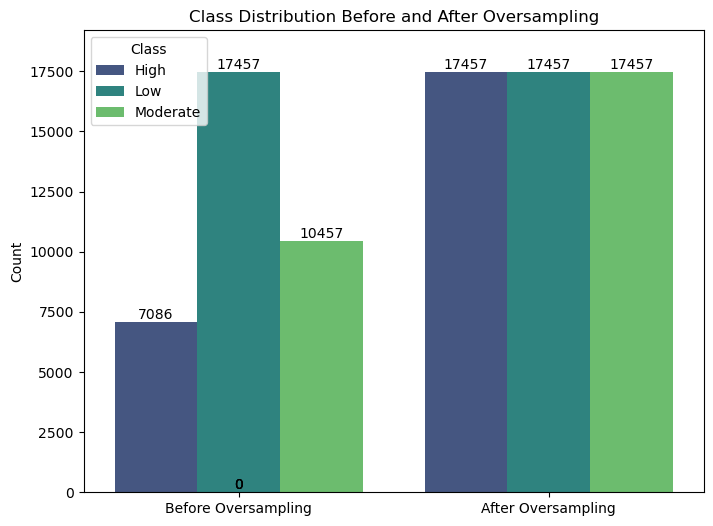

In [522]:
# Convert y_train and y_resampled to pandas Series if they're NumPy arrays
y_train_series = pd.Series(y_train) if not isinstance(y_train, pd.Series) else y_train
y_resampled_series = pd.Series(y_resampled) if not isinstance(y_resampled, pd.Series) else y_resampled

# Calculate class distributions before and after oversampling
class_dist_before = y_train_series.value_counts().sort_index()
class_dist_after = y_resampled_series.value_counts().sort_index()

# Print distributions
print("Class Distribution in Training Data Before Oversampling:")
print(class_dist_before)
print("\nClass Distribution in Training Data After Oversampling:")
print(class_dist_after)

# Prepare DataFrame for visualization
df_plot = pd.DataFrame({
    'Class': class_dist_before.index.tolist() * 2,
    'Count': list(class_dist_before) + list(class_dist_after),
    'Sampling': ['Before Oversampling'] * len(class_dist_before) + ['After Oversampling'] * len(class_dist_after)
})

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Sampling', y='Count', hue='Class', data=df_plot, palette='viridis')

plt.title('Class Distribution Before and After Oversampling')
plt.xlabel('')
plt.ylabel('Count')
plt.ylim(0, max(class_dist_after) * 1.1)  # Ensure full count range

# Add value labels on bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.show()

Decision Tree:
Accuracy: 37.83%, Precision: 39.16%, Recall: 37.83%, F1-score: 38.40%
Classification Report:
               precision    recall  f1-score   support

        High       0.21      0.25      0.23      2986
         Low       0.52      0.47      0.49      7567
    Moderate       0.30      0.31      0.31      4447

    accuracy                           0.38     15000
   macro avg       0.34      0.34      0.34     15000
weighted avg       0.39      0.38      0.38     15000

Actual class distribution for Decision Tree: Counter({'Low': 7567, 'Moderate': 4447, 'High': 2986})
Predicted class distribution for Decision Tree: Counter({'Low': 6874, 'Moderate': 4574, 'High': 3552})
--------------------------------------------------


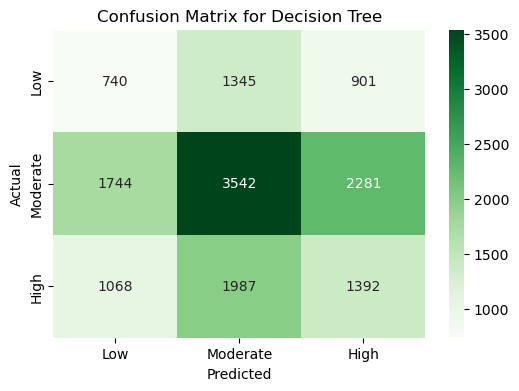

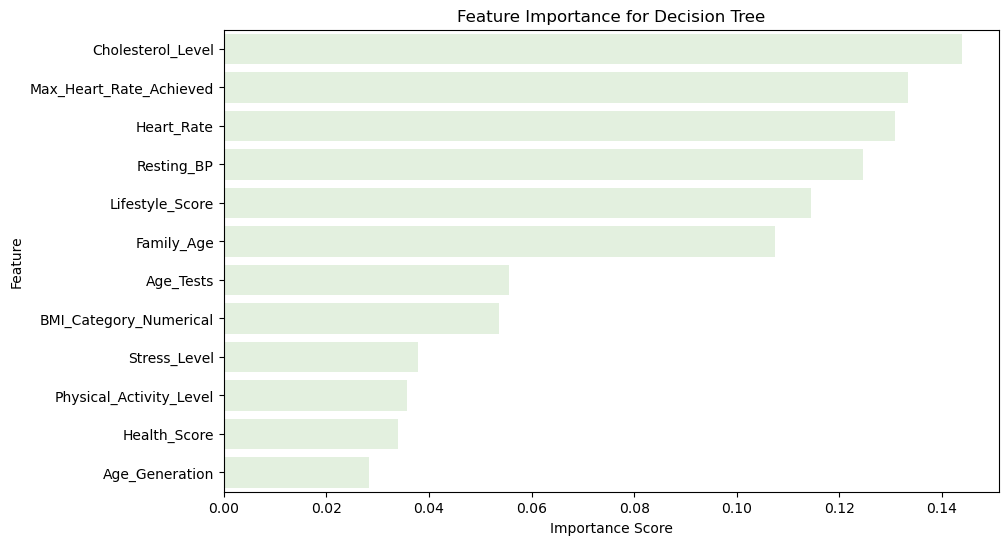

Logistic Regression:
Accuracy: 32.33%, Precision: 38.48%, Recall: 32.33%, F1-score: 33.48%
Classification Report:
               precision    recall  f1-score   support

        High       0.20      0.40      0.27      2986
         Low       0.51      0.31      0.38      7567
    Moderate       0.30      0.30      0.30      4447

    accuracy                           0.32     15000
   macro avg       0.34      0.34      0.32     15000
weighted avg       0.38      0.32      0.33     15000

Actual class distribution for Logistic Regression: Counter({'Low': 7567, 'Moderate': 4447, 'High': 2986})
Predicted class distribution for Logistic Regression: Counter({'High': 6027, 'Low': 4580, 'Moderate': 4393})
--------------------------------------------------


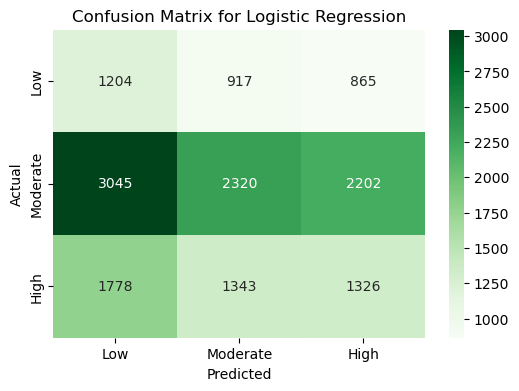

KNN:
Accuracy: 32.83%, Precision: 38.26%, Recall: 32.83%, F1-score: 34.04%
Classification Report:
               precision    recall  f1-score   support

        High       0.20      0.39      0.27      2986
         Low       0.51      0.34      0.41      7567
    Moderate       0.29      0.27      0.28      4447

    accuracy                           0.33     15000
   macro avg       0.33      0.33      0.32     15000
weighted avg       0.38      0.33      0.34     15000

Actual class distribution for KNN: Counter({'Low': 7567, 'Moderate': 4447, 'High': 2986})
Predicted class distribution for KNN: Counter({'High': 5837, 'Low': 5020, 'Moderate': 4143})
--------------------------------------------------


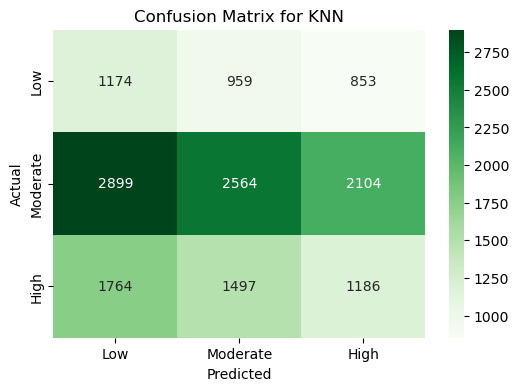

Random Forest:
Accuracy: 44.53%, Precision: 38.76%, Recall: 44.53%, F1-score: 39.67%
Classification Report:
               precision    recall  f1-score   support

        High       0.21      0.09      0.12      2986
         Low       0.51      0.74      0.60      7567
    Moderate       0.30      0.19      0.23      4447

    accuracy                           0.45     15000
   macro avg       0.34      0.34      0.32     15000
weighted avg       0.39      0.45      0.40     15000

Actual class distribution for Random Forest: Counter({'Low': 7567, 'Moderate': 4447, 'High': 2986})
Predicted class distribution for Random Forest: Counter({'Low': 10995, 'Moderate': 2789, 'High': 1216})
--------------------------------------------------


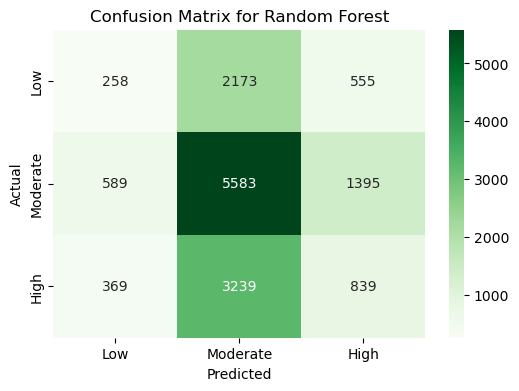

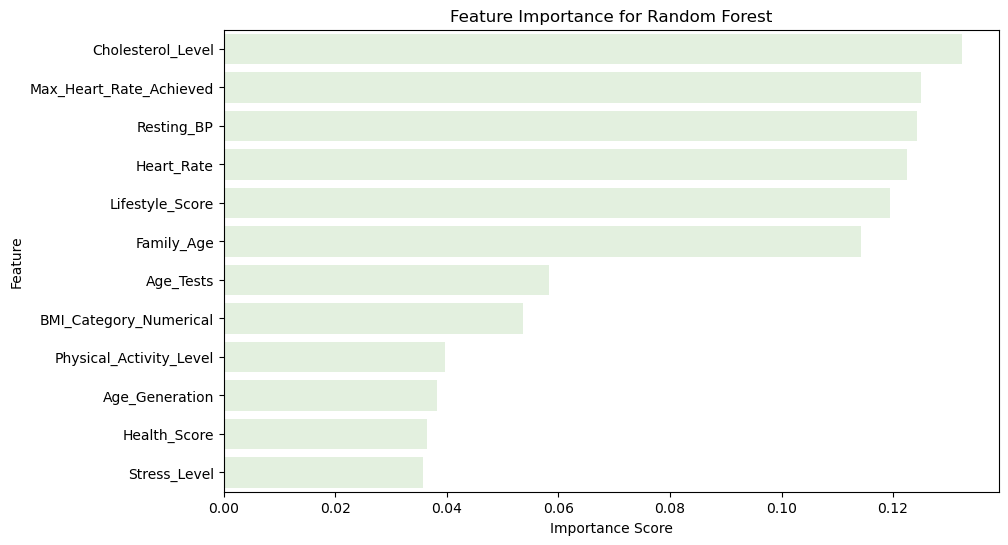

<Figure size 1200x600 with 0 Axes>

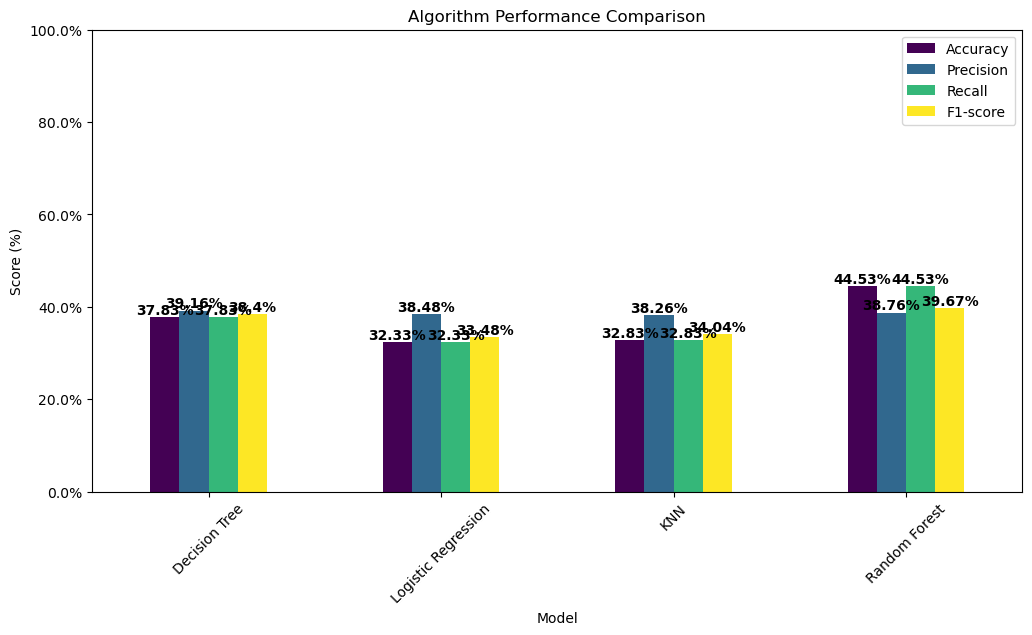

In [523]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
# Prepare models
models = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier())
]

# Prepare lists to store results
names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Evaluate each model in turn
for name, model in models:
    # Train the model using training data (SMOTE for handling imbalance)
    model.fit(X_resampled, y_resampled)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Compute scores and round to 2 decimal places
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)  # Convert to percentage and round
    precision = round(precision_score(y_test, y_pred, average='weighted') * 100, 2)  # Convert to percentage and round
    recall = round(recall_score(y_test, y_pred, average='weighted') * 100, 2)  # Convert to percentage and round
    f1 = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)  # Convert to percentage and round

    # Append results
    names.append(name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"{name}:")
    print(f"Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1-score: {f1:.2f}%")
    print(f"Classification Report:\n", classification_report(y_test, y_pred))
    
    # Print actual and predicted class distribution for the current model
    print(f"Actual class distribution for {name}: {Counter(y_test)}")
    print(f"Predicted class distribution for {name}: {Counter(y_pred)}")
    print("-" * 50)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                xticklabels=['Low', 'Moderate', 'High'], 
                yticklabels=['Low', 'Moderate', 'High'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Feature Importance for Decision Tree and Random Forest
    if name in ['Decision Tree', 'Random Forest']:
        feature_importances = model.feature_importances_
        feature_names = X_resampled.columns

        # Create DataFrame and sort by importance
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        sns.set_palette("Greens")
        sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'])
        plt.title(f'Feature Importance for {name}')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.show()

# Convert results into a DataFrame for plotting
metrics_df = pd.DataFrame({
    'Model': names,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-score': f1_scores
})

# Plot multiple metrics per model
plt.figure(figsize=(12, 6))
metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 6), colormap='viridis')

plt.title('Algorithm Performance Comparison')
plt.ylabel('Score (%)')  # Change the label to reflect percentage
plt.ylim(0, 100)  # Limiting y-axis from 0 to 100 (percentage range)
plt.xticks(rotation=45)

# Adding value labels on bars as percentage, rounded to 2 decimal places
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{round(p.get_height(), 2)}%',  # Round the value to 2 decimal places
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', 
                fontsize=10, color='black', fontweight='bold')

# Round y-axis ticks to 2 decimal places as well
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{round(x, 2)}%'))

plt.legend(loc='best')
plt.show()

In [524]:
from collections import Counter

print("Actual class distribution:", Counter(y_test))  
print("Predicted class distribution:", Counter(y_pred))

Actual class distribution: Counter({'Low': 7567, 'Moderate': 4447, 'High': 2986})
Predicted class distribution: Counter({'Low': 10995, 'Moderate': 2789, 'High': 1216})


In [525]:
# Initialize the classifier
clf = RandomForestClassifier()

# Perform 10-fold cross-validation
scores = cross_val_score(clf, X_resampled, y_resampled, cv=10)  # 'cv' specifies the number of folds
print(f"Cross-validation scores: {scores}")
print(f"Mean score: {scores.mean()}")

Cross-validation scores: [0.47938144 0.48233722 0.47355356 0.46782509 0.64464388 0.6599198
 0.77372542 0.75634905 0.7576857  0.75883139]
Mean score: 0.6254252552712756
